# Halpha luminosity function calculations

This notebook has a collection of calculations to derive number counts from a luminosity function.

In [1]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot
matplotlib.rcParams.update({'axes.labelsize': 'large'}) 

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

mpc_to_cm = 3.086e+24

In [3]:
def flux_to_lum(f, z):
    """ Convert flux to luminosity. """
    return f * 4 * np.pi * (cosmo.luminosity_distance(z).value * mpc_to_cm)**2

def redshift_shell_volume(zmin, zmax, area=1):
    """ """
    fsky = area * 1. / (4*np.pi*(180/np.pi)**2) 
    rmin = cosmo.comoving_distance(zmin).value
    rmax = cosmo.comoving_distance(zmax).value
    v = fsky * 4./3 * np.pi * (rmax**3 - rmin**3)
    return v
    
def pozzetti_model1(L, z=1., phi_star=10**-2.80, L_star=10**41.50, alpha=-1.35, d=2., e=1., z_break=1.3):
    """ Pozzetti et al 2016 model 1 luminosity function """
    L_star_z = L_star * (1+z)**d
    
    if z < z_break:
        phi_star_z = phi_star * (1 + z)**e
    else:
        phi_star_z = phi_star * (1 + z_break)**(2*e) * (1 + z)**-e

    x = L/L_star_z
    
    return  1./L_star_z * phi_star_z * x**alpha * np.exp(-x)

def count(fluxlim=2e-16, zlow=0.9, zhigh=1.7, dz=0.05, area=1):
    """ Count galaxies above the flux limit in a redshift bin. """
    
    steps = max(2, int((zhigh - zlow)/dz))
    zz = np.linspace(zlow, zhigh, steps)
    count = 0
    for i in range(len(zz)-1):

        zmid = (zz[i] + zz[i+1])/2.

        L0 = flux_to_lum(fluxlim, zmid)

#         print "z = {:3.2f} log10L_0 = {:6.3f}".format(zmid, np.log10(L0))

        lumfunc = lambda x: pozzetti_model1(x, z=zmid)
        n, info = scipy.integrate.quad(lumfunc, L0, 10**46)

        volume = redshift_shell_volume(zz[i], zz[i+1], area=area)

        n *= volume

        count += n
    return count

# Flux-limited galaxy counts
The redshift range is set to match WISP counts presented in Pozzetti et al Fig 4

In [4]:
fluxlim = np.logspace(-17, -15., 20)
n = []
for f in fluxlim:
    n.append(count(f, zlow=0.7, zhigh=1.5, dz=.05, area=1))
n = np.array(n)

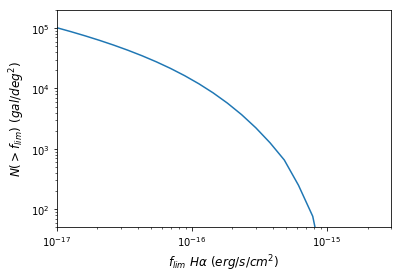

In [5]:
pyplot.loglog(fluxlim, n)
pyplot.ylim(50, 2e5)
pyplot.xlim(1e-17, 3e-15)
pyplot.xlabel("$f_{lim}\ H\\alpha\ (erg/s/cm^2)$")
r=pyplot.ylabel("$N(>f_{lim})\ (gal/deg^2)$")

# Sensitivity of counts to flux limit
Compute the derivative of the counts with respect to flux limit.

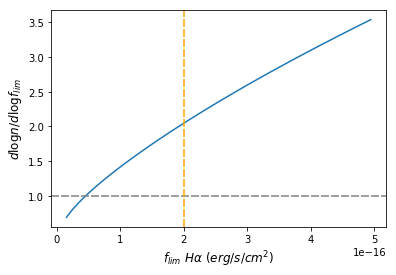

In [6]:
fluxlim = np.linspace(1e-17, 5e-16, 50)
n = []
for f in fluxlim:
    n.append(count(f, zlow=0.9, zhigh=1.7, dz=.05, area=1))
n = np.array(n)

logn = np.log10(n)
logf = np.log10(fluxlim)

dn = logn[1:] - logn[:-1]
df = logf[1:] - logf[:-1]

dndf = -dn / df

x = (fluxlim[1:] + fluxlim[:-1])/2.
pyplot.plot(x, dndf)
pyplot.axhline(1, c='grey', dashes=(4,1))
pyplot.axvline(2e-16, c='orange', dashes=(4,1))
pyplot.xlabel("$f_{lim}\ H\\alpha\ (erg/s/cm^2)$")
r=pyplot.ylabel("$ d \log n / d \log f_{lim}$")

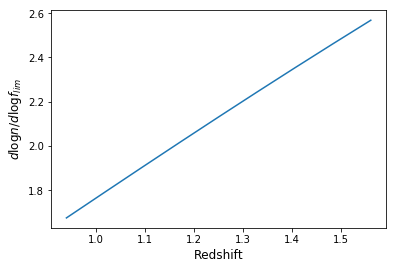

In [7]:
# Trend with redshift

f_lim = 2e-16
a = 1.05
zz = np.linspace(0.9, 1.6, 10)

y = []
for i in range(len(zz)-1):
    n1 = count(f_lim, zlow=zz[i], zhigh=zz[i+1])
    n2 = count(f_lim*a, zlow=zz[i], zhigh=zz[i+1])
    
    dlogn = np.log10(n1) - np.log10(n2)
    dlogf = np.log10(f_lim) - np.log10(f_lim*a)
    y.append(dlogn/np.log10(a))

zmid = (zz[1:]+zz[:-1])/2.
pyplot.plot(zmid, y)
pyplot.xlabel("Redshift")
r=pyplot.ylabel("$d\log n/d \log f_{lim}$")